In [2]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/anime faces.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/anime faces'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
imgae_dir = '/content/drive/MyDrive/Colab Notebooks/anime faces/anime faces/cropped'
#  line creates a list of image file paths by joining the image file names
#  obtained from the specified directory
images = [os.path.join(imgae_dir, image) for image in os.listdir(imgae_dir)]
images[:2]

['/content/drive/MyDrive/Colab Notebooks/anime faces/anime faces/cropped/10009_2004.jpg',
 '/content/drive/MyDrive/Colab Notebooks/anime faces/anime faces/cropped/10032_2004.jpg']

Preprocessing image

In [23]:
image_size = 64

def preprocess(image):
  image = tf.io.read_file(image) #read image as file
  image = tf.io.decode_jpeg(image) #decode file as jpeg
  image = tf.cast(image, tf.float32) #casting image to 34bit floating value
  image = tf.image.resize(image, (image_size, image_size)) #resizing the image
  image = image / 255 #normalizing
  image = tf.reshape(image, shape = (image_size, image_size, 3)) #reshaping into 3d. 3 is for rgb channels
  return image

In [24]:
batch_size = 128

# creates a TensorFlow Dataset object from the list of image file paths
training_dataset = tf.data.Dataset.from_tensor_slices(images)
training_dataset = training_dataset.map(preprocess)

# shuffles the images randomly using shuffle(1000),
# where 1000 is the buffer size used for shuffling.
# batches the images together using batch(batch_size),
# where batch_size is the number of images that will be processed together in each batch during training.
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [22]:
len(training_dataset)

241

Visualization

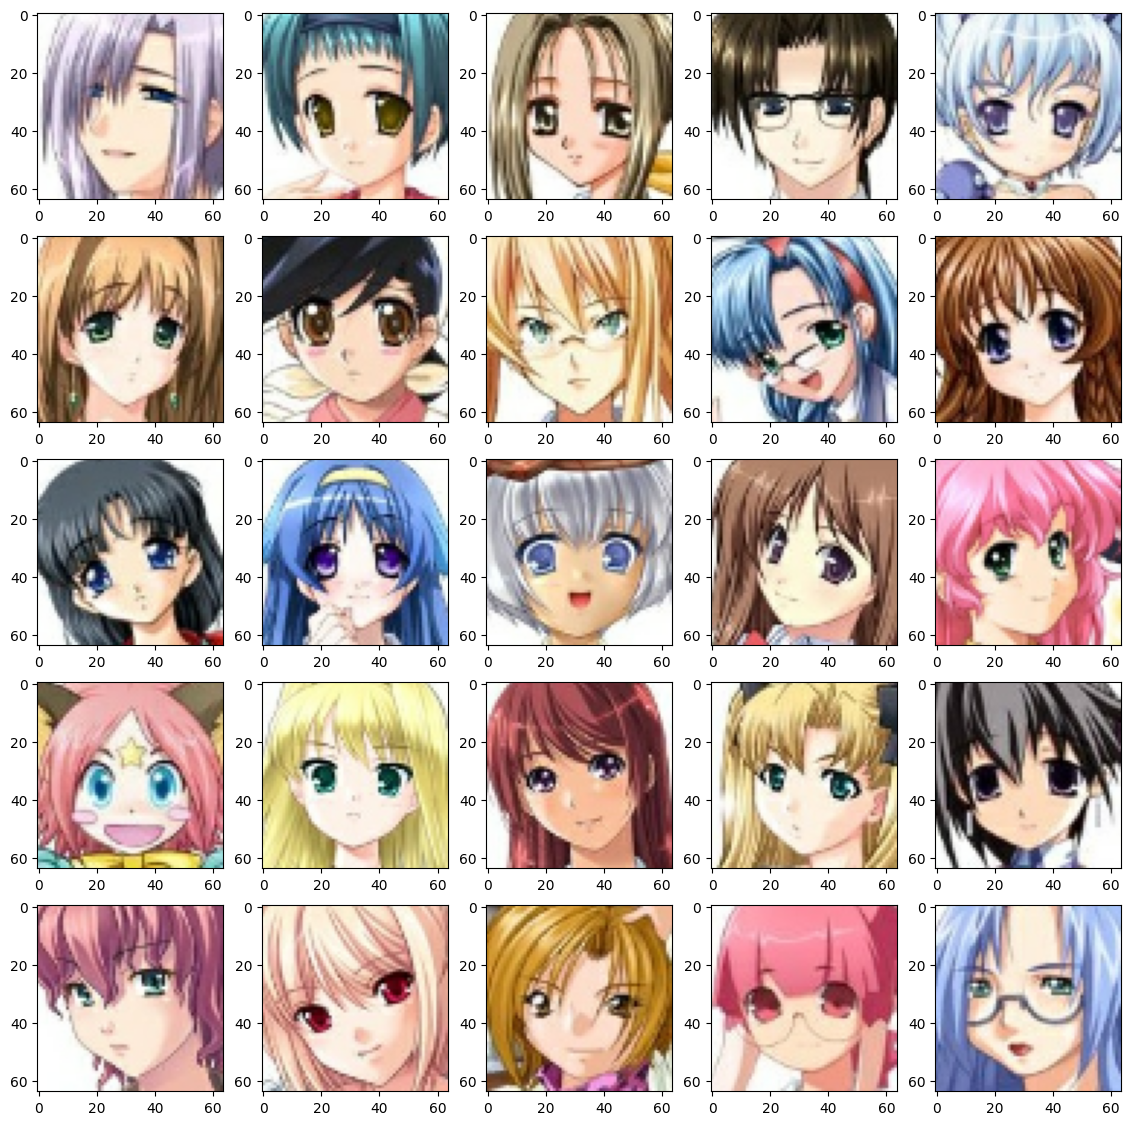

In [25]:
fig, axes = plt.subplots(5,5, figsize = (14,14))
# taking 25 samples from the training dataset
# and storing them in a list
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

Building our model

In [26]:
latent_dim = 512 #for bottleneck

In [29]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.activation import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K

In [31]:
leakyRelu = LeakyReLU(0.02)

# encoder architecture
encoder_input = Input(shape = (64, 64, 3))

x = Conv2D(32, kernel_size=5, activation = leakyRelu, strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=(5,5), activation = leakyRelu, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

#bottleneck / sampling layer
# for sampling layer in VAE we need mean, varience and epilison layer
mean = Dense(latent_dim)(encoder_output)
varience = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))
sigma = tf.exp(0.5 * varience) # calculating the standard deviation

# using reparameterization trick
# z = mean + sigma * epsilon
z_eps = Multiply()([sigma, epsilon])
z = Add()([mean, z_eps])

encoder = Model(encoder_input, outputs = [mean, varience, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   51264       ['batch_normalization_6[0][

In [32]:
# decoder architecture
decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 256)        1

Defining the loss function

In [33]:
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred)) # simple mean square error

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))  #kl divergence formula
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

Combining encoder and decoder to create VAE

In [34]:
mean, varience, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mean, varience)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 512),        13802688    ['input_2[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    13283023    ['encoder[0][2]']                
                                                                                                

In [35]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

Training VAE

In [36]:
# Visualing the image before training
random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

1/1 [==============================] - 9s 9s/step


In [ ]:
from keras.optimizers import Adam

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 50

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

Epoch:  1
1/1 [==============================] - 0s 20ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09360368 - KL loss: 0.001076346
Epoch: 1 - Step: 1 - MSE loss: 0.094149865 - KL loss: 0.0008884332
Epoch: 1 - Step: 2 - MSE loss: 0.09513462 - KL loss: 0.0006889211
Epoch: 1 - Step: 3 - MSE loss: 0.096176 - KL loss: 0.0005329625
Epoch: 1 - Step: 4 - MSE loss: 0.09512439 - KL loss: 0.00040357708
Epoch: 1 - Step: 5 - MSE loss: 0.09664041 - KL loss: 0.0003181798
Epoch: 1 - Step: 6 - MSE loss: 0.09685183 - KL loss: 0.00025503043
Epoch: 1 - Step: 7 - MSE loss: 0.09501942 - KL loss: 0.00021481629
Epoch: 1 - Step: 8 - MSE loss: 0.09538457 - KL loss: 0.00019210295
Epoch: 1 - Step: 9 - MSE loss: 0.091792904 - KL loss: 0.00017140775
1/1 [==============================] - 0s 58ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.091807984 - KL loss: 0.00016594765
Epoch: 1 - Step: 11 - MSE loss: 0.09223601 - KL loss: 0.00017942344
Epoch: 1 - Step: 12 - MSE loss: 0.08944798 - KL loss: 0.00021433335
Epoch: 1 - Step: 

In [3]:
# visualize output

import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

DisabledFunctionError: ignored